# COMP579 Assignment 2


Sienna Hsu (260948832)

Ronald Truong (260427874)


**Coding: Tabular RL [70 points]**

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pickle
from google.colab import drive
drive.mount('/content/gdrive')
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.random.seed(123)

Mounted at /content/gdrive


In [ ]:
print("Gym version:", gym.__version__)

Gym version: 0.25.2


## Algorithms

In [ ]:
# numerically stable version
def softmax(x, temp):
  # write your solution here
  max_x = np.max(x)
  exp_vals = np.exp((x - max_x) / temp)
  return exp_vals / np.sum(exp_vals)

In [ ]:
class Sarsa:
  def __init__(self, env, alpha, gamma, temp):
    # write your solution here
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.temp = temp
    self.Q = np.zeros((env.observation_space.n, env.action_space.n))


  def select_action(self, s, greedy=False):
    # write your solution here
    if greedy:
      # if finished training, then choose the optimal policy
      return np.argmax(self.Q[s,:])
    else:
      # use softmax
      return np.random.choice(self.env.action_space.n, p=softmax(self.Q[s,:], self.temp))

  def update(self, s, a, r, s_prime, a_prime):
      self.Q[s,a] += self.alpha * (r + self.gamma * (self.Q[s_prime,a_prime]) - self.Q[s,a])


class ExpectedSarsa:
  def __init__(self, env, alpha, gamma, temp):
    # write your solution here
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.temp = temp
    self.Q = np.zeros((env.observation_space.n, env.action_space.n))


  def select_action(self, s, greedy=False):
    # write your solution here
    if greedy:
      # if finished training, then choose the optimal policy
      return np.argmax(self.Q[s,:])
    else:
      # use softmax
      return np.random.choice(self.env.action_space.n, p=softmax(self.Q[s,:], self.temp))


  def update(self, s, a, r, s_prime, a_prime):
    # write your solution here
    expected_term = 0
    p = softmax(self.Q[s_prime,:], self.temp)
    for action_i in range(self.env.action_space.n):
      expected_term += p[action_i] * self.Q[s_prime, action_i]

    self.Q[s,a] += self.alpha * (r + self.gamma * expected_term - self.Q[s,a])


# bonus question, optional
class Hybrid_Sarsa_Q:
  def __init__(self, env, alpha, gamma, temp, misleading_alpha=0.5):
    # write your solution here
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.temp = temp
    self.Q = np.zeros((env.observation_space.n, env.action_space.n))
    self.misleading_alpha = misleading_alpha


  def select_action(self, s, greedy=False):
    # write your solution here
    if greedy:
      # if finished training, then choose the optimal policy
      return np.argmax(self.Q[s,:])
    else:
      # use softmax
      return np.random.choice(self.env.action_space.n, p=softmax(self.Q[s,:], self.temp))


  def update(self, s, a, r, s_prime, a_prime):
    # write your solution here
    expected_term = 0
    p = softmax(self.Q[s_prime,:], self.temp)
    for action_i in range(self.env.action_space.n):
      expected_term += p[action_i] * self.Q[s_prime, action_i]

    target_term = r + self.gamma * ((1-self.misleading_alpha) * max(self.Q[s_prime,:]) \
                                    + self.misleading_alpha * expected_term)
    self.Q[s,a] += self.alpha * (target_term - self.Q[s,a])

## Helper functions

In [ ]:
# function that runs each episode
def run_episode(algo, ep_num, test=False, verbose=False):

  total_r = 0

  if test:
    # initialize s and a
    s = algo.env.reset()
    a = algo.select_action(s, greedy=True)
    done = False

    while not done:
      # take action a and observe r and s_prime
      s_prime, r, done, info = algo.env.step(a)
      total_r = r + algo.gamma * total_r

      # choose a_prime from s_prime using greedy policy
      a_prime = algo.select_action(s_prime, greedy=True)

      # update s_prime and a_prime
      s = s_prime
      a = a_prime
    if verbose:
      print(f'Testing completed with reward {total_r}')

  else:
    # initialize s and a
    s = algo.env.reset()
    a = algo.select_action(s)
    done = False

    while not done:
      # take action a and observe r and s_prime
      s_prime, r, done, info = algo.env.step(a)
      total_r = r + algo.gamma * total_r

      # choose a_prime from s_prime using softmax policy
      a_prime = algo.select_action(s_prime)

      # update Q table
      algo.update(s, a, r, s_prime, a_prime)

      # update s_prime and a_prime
      s = s_prime
      a = a_prime

    if verbose:
      print(f'Training completed for episode {ep_num} with reward {total_r}')

  return total_r


# function that runs each hyperparameter setting
def run_hyperparams(algos, alpha, temp, gamma=0.99, trial_num=10, seg_num=500, train_ep_num=10, test_ep_num=1):
  # arrays to keep track of rewards
  # dimension is number of algos x trial_num x seg_num x (train_ep_num + test_ep_num)
  rewards = []

  for algorithm in algos:
    algo_r = []

    for trial_i in range(trial_num):
      algo = algorithm(env, alpha, gamma, temp)  # each trial is independent
      trial_r = []

      for seg_i in range(seg_num):
        seg_r = []

        # training
        for train_ep_i in range(train_ep_num):
          r = run_episode(algo, train_ep_i)
          seg_r.append(r)

        # testing
        for test_ep_i in range(test_ep_num):
          r = run_episode(algo, 'x', test=True)
          seg_r.append(r)

        trial_r.append(seg_r)

      algo_r.append(trial_r)

    rewards.append(algo_r)
  return rewards

## Experiments

In [ ]:
env_name = 'Taxi-v3'
env = gym.make(env_name)
print("Action space:", env.action_space)
print("State space:", env.observation_space)

Action space: Discrete(6)
State space: Discrete(500)


In [ ]:
# parameters for experiments
algos = [Sarsa, ExpectedSarsa, Hybrid_Sarsa_Q]
alphas = [0.01, 0.1, 0.5, 0.9, 0.99, 0.999]
temps = [0.01, 0.1, 0.5, 0.9, 0.99]
trial_n = 10
segment_n = 500
train_ep_n = 10
test_ep_n = 1
ep_n = train_ep_n + test_ep_n

alpha_labels = [str(x) for x in alphas]

In [ ]:
rewards_diff_params = []
for alpha in alphas:
  alpha_reward = []
  for temp in temps:
    alpha_reward.append(run_hyperparams(algos, alpha, temp))
  rewards_diff_params.append(alpha_reward)

In [ ]:
with open('/content/gdrive/My Drive/result_all.pkl', 'wb') as f:
  pickle.dump(rewards_diff_params, f)

## Plots

In [ ]:
with open('/content/gdrive/My Drive/result_all.pkl', "rb") as fp:   # Unpickling
  rewards = pickle.load(fp)

In [ ]:
# function to check the dimension of nested list
def nested_list_dimensions(lst):
    if not isinstance(lst, list):
        return ()  # Return an empty tuple if the input is not a list

    dimensions = [len(lst)]  # Get the length of the current list
    if lst:  # Check if the current list is not empty
        dimensions.extend(nested_list_dimensions(lst[0]))  # Recursively get dimensions of the first element

    return tuple(dimensions)

In [ ]:
dimensions = nested_list_dimensions(rewards)
print("Dimensions of nested list:", dimensions)

Dimensions of nested list: (6, 5, 3, 10, 500, 11)


In [ ]:
"""
The dimensions are respectively
- 6 alphas
- 5 temps
- 3 algorithms
- 10 trials
- 500 segments
- 11 episodes (10 training and 1 testing)
"""

'\nThe dimensions are respectively\n- 6 alphas\n- 5 temps\n- 3 algorithms\n- 10 trials\n- 500 segments\n- 11 episodes (10 training and 1 testing)\n'

### Plot 1
A graph that shows the effect of the parameters on the final training performance. The x-axis shows the different parameters (learning rate), and the y-axis shows the return
of the agent (averaged over the last 10 training episodes and the 10 runs).

In [ ]:
algo_labels = ["Sarsa", "Expected Sarsa", "Hybrid Q-Sarsa"]
two_algos = [Sarsa, ExpectedSarsa] # for graphs with only these two algorithms

Highest reward for Sarsa T = 0.01 is with alpha = 0.99 at 9.01524168353306.
Highest reward for Sarsa T = 0.1 is with alpha = 0.1 at 8.9235400841282.
Highest reward for Sarsa T = 0.5 is with alpha = 0.1 at 8.918560353764468.
Highest reward for Sarsa T = 0.9 is with alpha = 0.1 at 8.473900397242982.
Highest reward for Sarsa T = 0.99 is with alpha = 0.1 at 8.907703285262462.
Highest reward for Expected Sarsa T = 0.01 is with alpha = 0.99 at 8.77973432170861.
Highest reward for Expected Sarsa T = 0.1 is with alpha = 0.1 at 8.823235033233322.
Highest reward for Expected Sarsa T = 0.5 is with alpha = 0.1 at 8.856997621281025.
Highest reward for Expected Sarsa T = 0.9 is with alpha = 0.1 at 8.866899787089967.
Highest reward for Expected Sarsa T = 0.99 is with alpha = 0.1 at 8.60907276327466.
Highest reward for Hybrid Q-Sarsa T = 0.01 is with alpha = 0.999 at 9.025440554648682.
Highest reward for Hybrid Q-Sarsa T = 0.1 is with alpha = 0.5 at 8.70919210127024.
Highest reward for Hybrid Q-Sarsa 

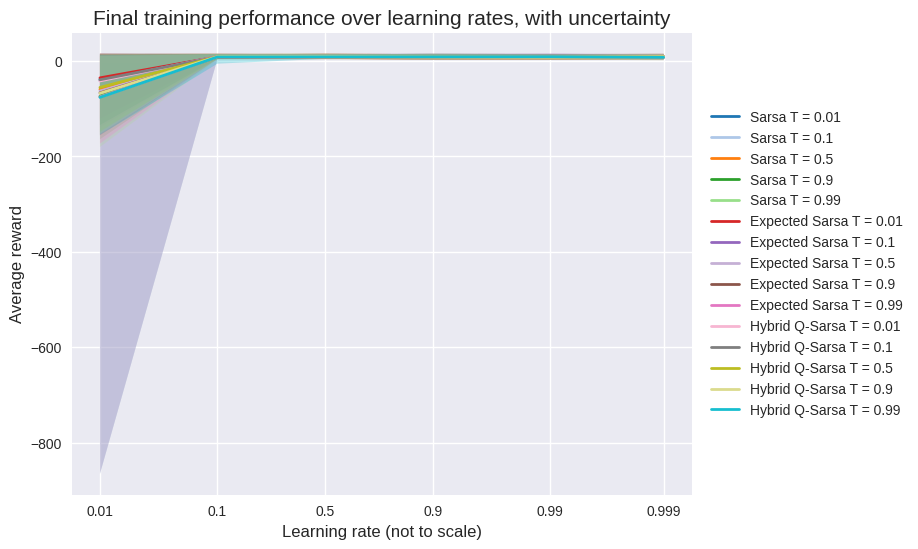

In [ ]:
NUM_COLORS = len(algos) * len(temps)
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(8, 6))
cm = plt.get_cmap('tab20')
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

x = alphas

for algo_i, algo in enumerate(algos):
  for temp_i, temp in enumerate(temps):
    max_r_all = []  # the maximum reward for each learning rate
    min_r_all = []  # the minimum reward for each learning rate
    y = []  # the mean reward for each learning rate

    for alpha_i, alpha in enumerate(alphas):
      label = algo_labels[algo_i] + " T = " + str(temp)
      r_array = [] # all the rewards of the last ten training episodes of each trial

      for trial_i in range(trial_n):
        last_ten_train_eps = rewards[alpha_i][temp_i][algo_i][trial_i][-1][:11]
        r_array += last_ten_train_eps

      min_r_all.append(min(r_array))
      max_r_all.append(max(r_array))
      mean_r = sum(r_array) / len(r_array)
      y.append(mean_r)

    ax.fill_between(x, max_r_all, min_r_all, alpha=.3, linewidth=0)
    ax.plot(x, y, linewidth=2, label=label)
    max_y = max(y)
    max_y_index = y.index(max_y)
    print(f'Highest reward for {label} is with alpha = {alphas[max_y_index]} at {max_y}.')

ax.set_xscale('logit')
ax.set(xticks=x)
ax.set_xticklabels(alpha_labels)  # Specify the tick labels
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=1)
ax.set_xlabel("Learning rate (not to scale)", fontsize=12)
ax.set_ylabel("Average reward", fontsize=12)
ax.set_title("Final training performance over learning rates, with uncertainty", fontsize=15)
plt.show()


Highest reward for Sarsa T = 0.01 is with alpha = 0.99 at 9.01524168353306.
Highest reward for Sarsa T = 0.1 is with alpha = 0.1 at 8.9235400841282.
Highest reward for Sarsa T = 0.5 is with alpha = 0.1 at 8.918560353764468.
Highest reward for Sarsa T = 0.9 is with alpha = 0.1 at 8.473900397242982.
Highest reward for Sarsa T = 0.99 is with alpha = 0.1 at 8.907703285262462.
Highest reward for Expected Sarsa T = 0.01 is with alpha = 0.99 at 8.77973432170861.
Highest reward for Expected Sarsa T = 0.1 is with alpha = 0.1 at 8.823235033233322.
Highest reward for Expected Sarsa T = 0.5 is with alpha = 0.1 at 8.856997621281025.
Highest reward for Expected Sarsa T = 0.9 is with alpha = 0.1 at 8.866899787089967.
Highest reward for Expected Sarsa T = 0.99 is with alpha = 0.1 at 8.60907276327466.
Highest reward for Hybrid Q-Sarsa T = 0.01 is with alpha = 0.999 at 9.025440554648682.
Highest reward for Hybrid Q-Sarsa T = 0.1 is with alpha = 0.5 at 8.70919210127024.
Highest reward for Hybrid Q-Sarsa 

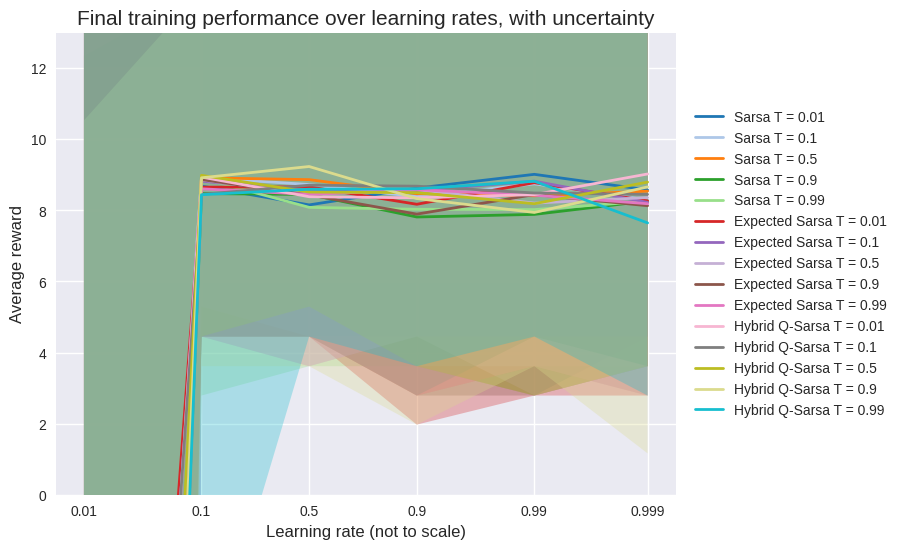

In [ ]:
NUM_COLORS = len(algos) * len(temps)
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(8, 6))
cm = plt.get_cmap('tab20')
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

x = alphas

for algo_i, algo in enumerate(algos):
  for temp_i, temp in enumerate(temps):
    max_r_all = []  # the maximum reward for each learning rate
    min_r_all = []  # the minimum reward for each learning rate
    y = []  # the mean reward for each learning rate

    for alpha_i, alpha in enumerate(alphas):
      label = algo_labels[algo_i] + " T = " + str(temp)
      r_array = [] # all the rewards of the last ten training episodes of each trial

      for trial_i in range(trial_n):
        last_ten_train_eps = rewards[alpha_i][temp_i][algo_i][trial_i][-1][:11]
        r_array += last_ten_train_eps

      min_r_all.append(min(r_array))
      max_r_all.append(max(r_array))
      mean_r = sum(r_array) / len(r_array)
      y.append(mean_r)

    ax.fill_between(x, max_r_all, min_r_all, alpha=.3, linewidth=0)
    ax.plot(x, y, linewidth=2, label=label)
    max_y = max(y)
    max_y_index = y.index(max_y)
    print(f'Highest reward for {label} is with alpha = {alphas[max_y_index]} at {max_y}.')

ax.set_ylim(0, 13)
ax.set_xscale('logit')
ax.set(xticks=x)
ax.set_xticklabels(alpha_labels)  # Specify the tick labels
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=1)
ax.set_xlabel("Learning rate (not to scale)", fontsize=12)
ax.set_ylabel("Average reward", fontsize=12)
ax.set_title("Final training performance over learning rates, with uncertainty", fontsize=15)
plt.show()


Highest reward for Sarsa T = 0.01 is with alpha = 0.99 at 9.01524168353306.
Highest reward for Sarsa T = 0.1 is with alpha = 0.1 at 8.9235400841282.
Highest reward for Sarsa T = 0.5 is with alpha = 0.1 at 8.918560353764468.
Highest reward for Sarsa T = 0.9 is with alpha = 0.1 at 8.473900397242982.
Highest reward for Sarsa T = 0.99 is with alpha = 0.1 at 8.907703285262462.
Highest reward for Expected Sarsa T = 0.01 is with alpha = 0.99 at 8.77973432170861.
Highest reward for Expected Sarsa T = 0.1 is with alpha = 0.1 at 8.823235033233322.
Highest reward for Expected Sarsa T = 0.5 is with alpha = 0.1 at 8.856997621281025.
Highest reward for Expected Sarsa T = 0.9 is with alpha = 0.1 at 8.866899787089967.
Highest reward for Expected Sarsa T = 0.99 is with alpha = 0.1 at 8.60907276327466.


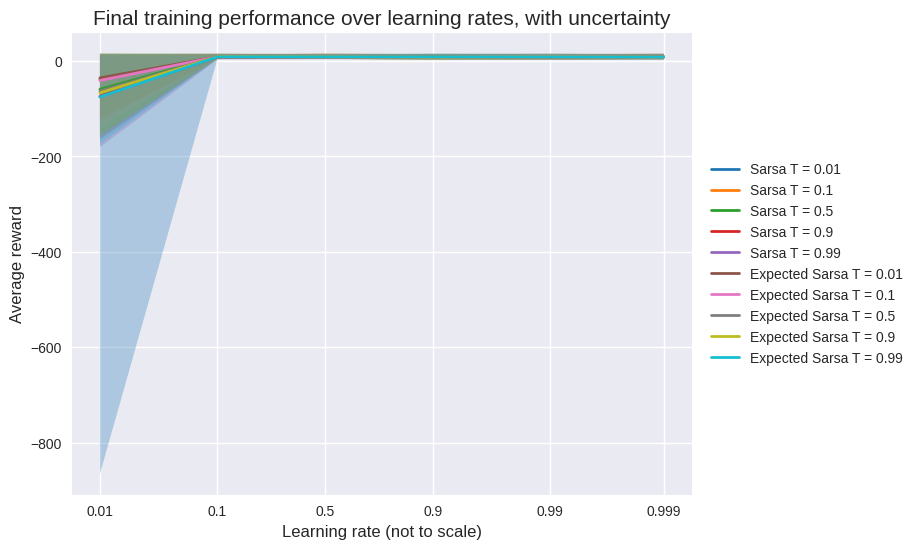

In [ ]:
# plot with only two algorithms
NUM_COLORS = len(two_algos) * len(temps)
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(8, 6))
cm = plt.get_cmap('tab20')
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

x = alphas

for algo_i, algo in enumerate(two_algos):
  for temp_i, temp in enumerate(temps):
    max_r_all = []  # the maximum reward for each learning rate
    min_r_all = []  # the minimum reward for each learning rate
    y = []  # the mean reward for each learning rate

    for alpha_i, alpha in enumerate(alphas):
      label = algo_labels[algo_i] + " T = " + str(temp)
      r_array = [] # all the rewards of the last ten training episodes of each trial

      for trial_i in range(trial_n):
        last_ten_train_eps = rewards[alpha_i][temp_i][algo_i][trial_i][-1][:11]
        r_array += last_ten_train_eps

      min_r_all.append(min(r_array))
      max_r_all.append(max(r_array))
      mean_r = sum(r_array) / len(r_array)
      y.append(mean_r)

    ax.fill_between(x, max_r_all, min_r_all, alpha=.3, linewidth=0)
    ax.plot(x, y, linewidth=2, label=label)
    max_y = max(y)
    max_y_index = y.index(max_y)
    print(f'Highest reward for {label} is with alpha = {alphas[max_y_index]} at {max_y}.')

ax.set_xscale('logit')
ax.set(xticks=x)
ax.set_xticklabels(alpha_labels)  # Specify the tick labels
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=1)
ax.set_xlabel("Learning rate (not to scale)", fontsize=12)
ax.set_ylabel("Average reward", fontsize=12)
ax.set_title("Final training performance over learning rates, with uncertainty", fontsize=15)
plt.show()

Highest reward for Sarsa T = 0.01 is with alpha = 0.99 at 9.01524168353306.
Highest reward for Sarsa T = 0.1 is with alpha = 0.1 at 8.9235400841282.
Highest reward for Sarsa T = 0.5 is with alpha = 0.1 at 8.918560353764468.
Highest reward for Sarsa T = 0.9 is with alpha = 0.1 at 8.473900397242982.
Highest reward for Sarsa T = 0.99 is with alpha = 0.1 at 8.907703285262462.
Highest reward for Expected Sarsa T = 0.01 is with alpha = 0.99 at 8.77973432170861.
Highest reward for Expected Sarsa T = 0.1 is with alpha = 0.1 at 8.823235033233322.
Highest reward for Expected Sarsa T = 0.5 is with alpha = 0.1 at 8.856997621281025.
Highest reward for Expected Sarsa T = 0.9 is with alpha = 0.1 at 8.866899787089967.
Highest reward for Expected Sarsa T = 0.99 is with alpha = 0.1 at 8.60907276327466.


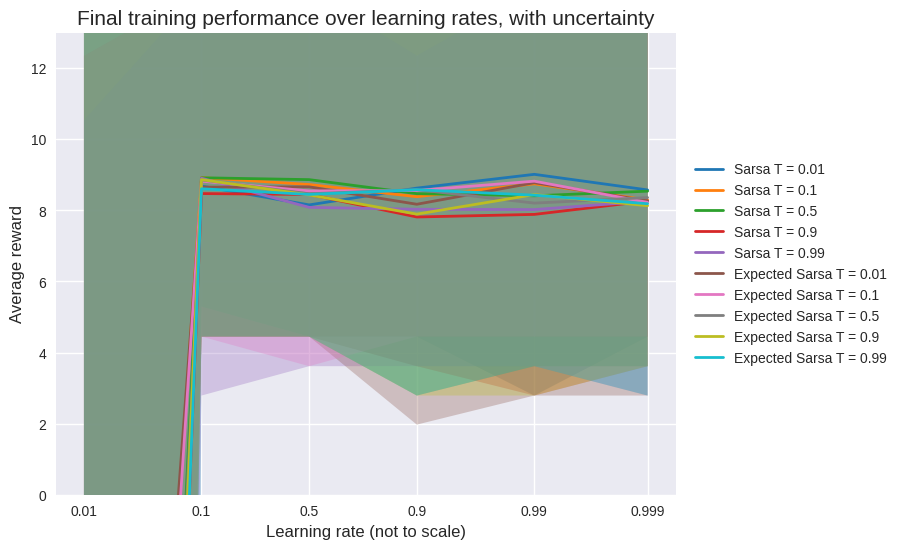

In [ ]:
# plot with only two algorithms
NUM_COLORS = len(two_algos) * len(temps)
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(8, 6))
cm = plt.get_cmap('tab20')
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

x = alphas

for algo_i, algo in enumerate(two_algos):
  for temp_i, temp in enumerate(temps):
    max_r_all = []  # the maximum reward for each learning rate
    min_r_all = []  # the minimum reward for each learning rate
    y = []  # the mean reward for each learning rate

    for alpha_i, alpha in enumerate(alphas):
      label = algo_labels[algo_i] + " T = " + str(temp)
      r_array = [] # all the rewards of the last ten training episodes of each trial

      for trial_i in range(trial_n):
        last_ten_train_eps = rewards[alpha_i][temp_i][algo_i][trial_i][-1][:11]
        r_array += last_ten_train_eps

      min_r_all.append(min(r_array))
      max_r_all.append(max(r_array))
      mean_r = sum(r_array) / len(r_array)
      y.append(mean_r)

    ax.fill_between(x, max_r_all, min_r_all, alpha=.3, linewidth=0)
    ax.plot(x, y, linewidth=2, label=label)
    max_y = max(y)
    max_y_index = y.index(max_y)
    print(f'Highest reward for {label} is with alpha = {alphas[max_y_index]} at {max_y}.')

ax.set_ylim(0, 13)
ax.set_xscale('logit')
ax.set(xticks=x)
ax.set_xticklabels(alpha_labels)  # Specify the tick labels
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=1)
ax.set_xlabel("Learning rate (not to scale)", fontsize=12)
ax.set_ylabel("Average reward", fontsize=12)
ax.set_title("Final training performance over learning rates, with uncertainty", fontsize=15)
plt.show()

Highest reward for Sarsa T = 0.01 is with alpha = 0.99 at 9.01524168353306.
Highest reward for Sarsa T = 0.1 is with alpha = 0.1 at 8.9235400841282.
Highest reward for Sarsa T = 0.5 is with alpha = 0.1 at 8.918560353764468.
Highest reward for Sarsa T = 0.9 is with alpha = 0.1 at 8.473900397242982.
Highest reward for Sarsa T = 0.99 is with alpha = 0.1 at 8.907703285262462.
Highest reward for Expected Sarsa T = 0.01 is with alpha = 0.99 at 8.77973432170861.
Highest reward for Expected Sarsa T = 0.1 is with alpha = 0.1 at 8.823235033233322.
Highest reward for Expected Sarsa T = 0.5 is with alpha = 0.1 at 8.856997621281025.
Highest reward for Expected Sarsa T = 0.9 is with alpha = 0.1 at 8.866899787089967.
Highest reward for Expected Sarsa T = 0.99 is with alpha = 0.1 at 8.60907276327466.
Highest reward for Hybrid Q-Sarsa T = 0.01 is with alpha = 0.999 at 9.025440554648682.
Highest reward for Hybrid Q-Sarsa T = 0.1 is with alpha = 0.5 at 8.70919210127024.
Highest reward for Hybrid Q-Sarsa 

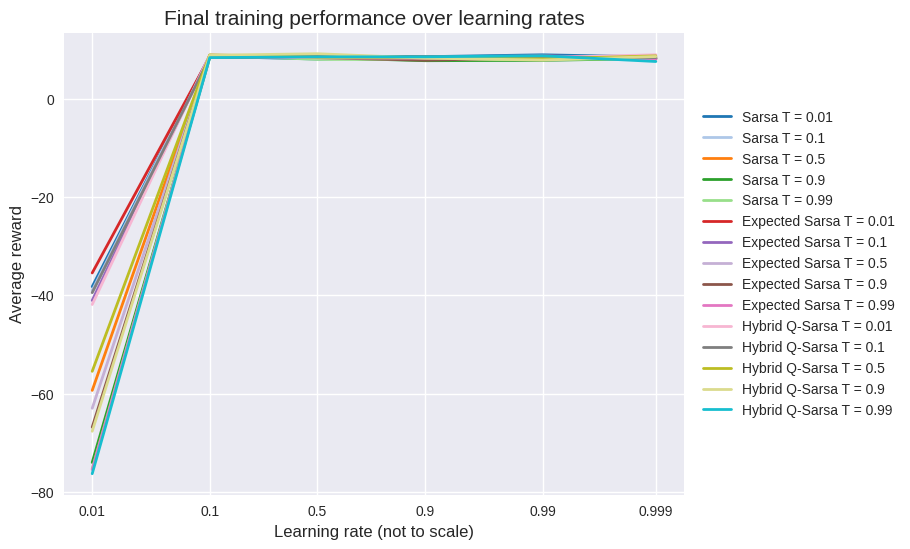

In [ ]:
NUM_COLORS = len(algos) * len(temps)
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(8, 6))
cm = plt.get_cmap('tab20')
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

x = alphas

for algo_i, algo in enumerate(algos):
  for temp_i, temp in enumerate(temps):
    y = []  # the mean reward for each learning rate

    for alpha_i, alpha in enumerate(alphas):
      label = algo_labels[algo_i] + " T = " + str(temp)
      r_array = [] # all the rewards of the last ten training episodes of each trial

      for trial_i in range(trial_n):
        last_ten_train_eps = rewards[alpha_i][temp_i][algo_i][trial_i][-1][:11]
        r_array += last_ten_train_eps

      mean_r = sum(r_array) / len(r_array)
      y.append(mean_r)

    ax.plot(x, y, linewidth=2, label=label)
    max_y = max(y)
    max_y_index = y.index(max_y)
    print(f'Highest reward for {label} is with alpha = {alphas[max_y_index]} at {max_y}.')


ax.set_xscale('logit')
ax.set(xticks=x)
ax.set_xticklabels(alpha_labels)  # Specify the tick labels
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=1)
ax.set_xlabel("Learning rate (not to scale)", fontsize=12)
ax.set_ylabel("Average reward", fontsize=12)
ax.set_title("Final training performance over learning rates", fontsize=15)
plt.show()

Highest reward for Sarsa T = 0.01 is with alpha = 0.99 at 9.01524168353306.
Highest reward for Sarsa T = 0.1 is with alpha = 0.1 at 8.9235400841282.
Highest reward for Sarsa T = 0.5 is with alpha = 0.1 at 8.918560353764468.
Highest reward for Sarsa T = 0.9 is with alpha = 0.1 at 8.473900397242982.
Highest reward for Sarsa T = 0.99 is with alpha = 0.1 at 8.907703285262462.
Highest reward for Expected Sarsa T = 0.01 is with alpha = 0.99 at 8.77973432170861.
Highest reward for Expected Sarsa T = 0.1 is with alpha = 0.1 at 8.823235033233322.
Highest reward for Expected Sarsa T = 0.5 is with alpha = 0.1 at 8.856997621281025.
Highest reward for Expected Sarsa T = 0.9 is with alpha = 0.1 at 8.866899787089967.
Highest reward for Expected Sarsa T = 0.99 is with alpha = 0.1 at 8.60907276327466.
Highest reward for Hybrid Q-Sarsa T = 0.01 is with alpha = 0.999 at 9.025440554648682.
Highest reward for Hybrid Q-Sarsa T = 0.1 is with alpha = 0.5 at 8.70919210127024.
Highest reward for Hybrid Q-Sarsa 

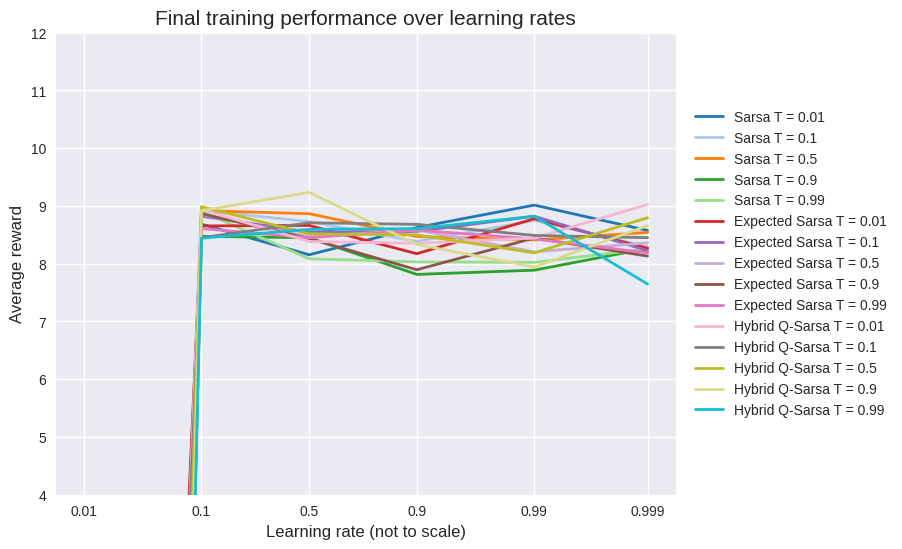

In [ ]:
NUM_COLORS = len(algos) * len(temps)
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(8, 6))
cm = plt.get_cmap('tab20')
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

x = alphas

for algo_i, algo in enumerate(algos):
  for temp_i, temp in enumerate(temps):
    y = []  # the mean reward for each learning rate

    for alpha_i, alpha in enumerate(alphas):
      label = algo_labels[algo_i] + " T = " + str(temp)
      r_array = [] # all the rewards of the last ten training episodes of each trial

      for trial_i in range(trial_n):
        last_ten_train_eps = rewards[alpha_i][temp_i][algo_i][trial_i][-1][:11]
        r_array += last_ten_train_eps

      mean_r = sum(r_array) / len(r_array)
      y.append(mean_r)

    ax.plot(x, y, linewidth=2, label=label)
    max_y = max(y)
    max_y_index = y.index(max_y)
    print(f'Highest reward for {label} is with alpha = {alphas[max_y_index]} at {max_y}.')

ax.set_ylim(4, 12)
ax.set_xscale('logit')
ax.set(xticks=x)
ax.set_xticklabels(alpha_labels)  # Specify the tick labels
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=1)
ax.set_xlabel("Learning rate (not to scale)", fontsize=12)
ax.set_ylabel("Average reward", fontsize=12)
ax.set_title("Final training performance over learning rates", fontsize=15)
plt.show()

Highest reward for Sarsa T = 0.01 is with alpha = 0.99 at 9.01524168353306.
Highest reward for Sarsa T = 0.1 is with alpha = 0.1 at 8.9235400841282.
Highest reward for Sarsa T = 0.5 is with alpha = 0.1 at 8.918560353764468.
Highest reward for Sarsa T = 0.9 is with alpha = 0.1 at 8.473900397242982.
Highest reward for Sarsa T = 0.99 is with alpha = 0.1 at 8.907703285262462.
Highest reward for Expected Sarsa T = 0.01 is with alpha = 0.99 at 8.77973432170861.
Highest reward for Expected Sarsa T = 0.1 is with alpha = 0.1 at 8.823235033233322.
Highest reward for Expected Sarsa T = 0.5 is with alpha = 0.1 at 8.856997621281025.
Highest reward for Expected Sarsa T = 0.9 is with alpha = 0.1 at 8.866899787089967.
Highest reward for Expected Sarsa T = 0.99 is with alpha = 0.1 at 8.60907276327466.


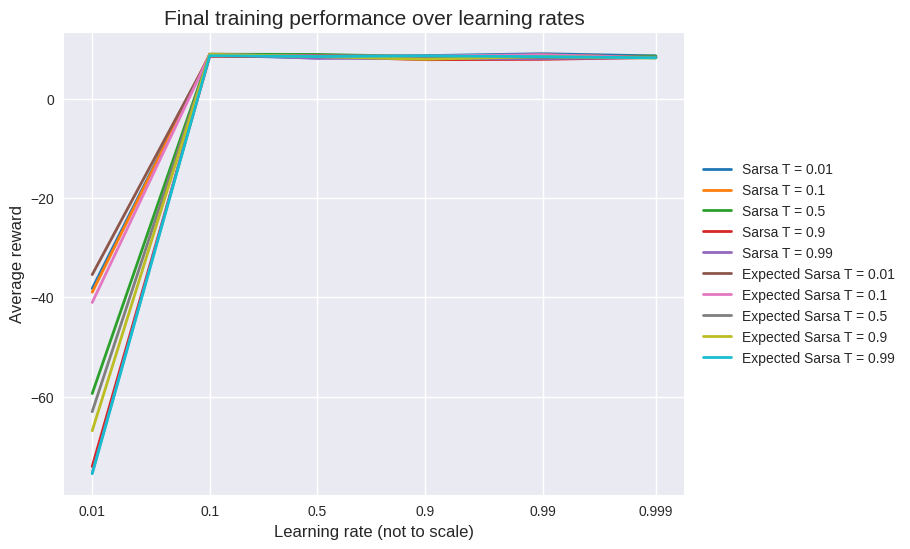

In [ ]:
# plots with only two algorithms
NUM_COLORS = len(two_algos) * len(temps)
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(8, 6))
cm = plt.get_cmap('tab20')
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

x = alphas

for algo_i, algo in enumerate(two_algos):
  for temp_i, temp in enumerate(temps):
    y = []  # the mean reward for each learning rate

    for alpha_i, alpha in enumerate(alphas):
      label = algo_labels[algo_i] + " T = " + str(temp)
      r_array = [] # all the rewards of the last ten training episodes of each trial

      for trial_i in range(trial_n):
        last_ten_train_eps = rewards[alpha_i][temp_i][algo_i][trial_i][-1][:11]
        r_array += last_ten_train_eps

      mean_r = sum(r_array) / len(r_array)
      y.append(mean_r)

    ax.plot(x, y, linewidth=2, label=label)
    max_y = max(y)
    max_y_index = y.index(max_y)
    print(f'Highest reward for {label} is with alpha = {alphas[max_y_index]} at {max_y}.')


ax.set_xscale('logit')
ax.set(xticks=x)
ax.set_xticklabels(alpha_labels)  # Specify the tick labels
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=1)
ax.set_xlabel("Learning rate (not to scale)", fontsize=12)
ax.set_ylabel("Average reward", fontsize=12)
ax.set_title("Final training performance over learning rates", fontsize=15)
plt.show()

Highest reward for Sarsa T = 0.01 is with alpha = 0.99 at 9.01524168353306.
Highest reward for Sarsa T = 0.1 is with alpha = 0.1 at 8.9235400841282.
Highest reward for Sarsa T = 0.5 is with alpha = 0.1 at 8.918560353764468.
Highest reward for Sarsa T = 0.9 is with alpha = 0.1 at 8.473900397242982.
Highest reward for Sarsa T = 0.99 is with alpha = 0.1 at 8.907703285262462.
Highest reward for Expected Sarsa T = 0.01 is with alpha = 0.99 at 8.77973432170861.
Highest reward for Expected Sarsa T = 0.1 is with alpha = 0.1 at 8.823235033233322.
Highest reward for Expected Sarsa T = 0.5 is with alpha = 0.1 at 8.856997621281025.
Highest reward for Expected Sarsa T = 0.9 is with alpha = 0.1 at 8.866899787089967.
Highest reward for Expected Sarsa T = 0.99 is with alpha = 0.1 at 8.60907276327466.


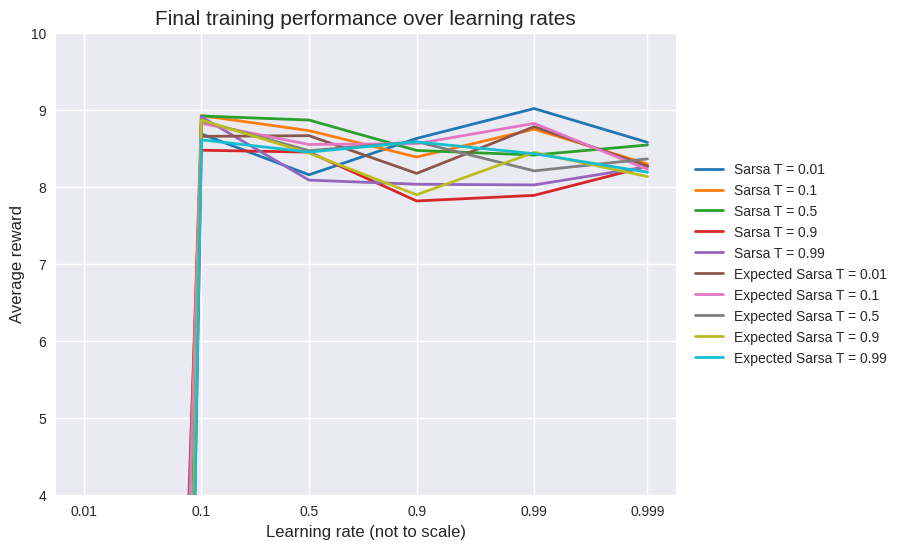

In [ ]:
# plots with only two algorithms
NUM_COLORS = len(two_algos) * len(temps)
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(8, 6))
cm = plt.get_cmap('tab20')
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

x = alphas

for algo_i, algo in enumerate(two_algos):
  for temp_i, temp in enumerate(temps):
    y = []  # the mean reward for each learning rate

    for alpha_i, alpha in enumerate(alphas):
      label = algo_labels[algo_i] + " T = " + str(temp)
      r_array = [] # all the rewards of the last ten training episodes of each trial

      for trial_i in range(trial_n):
        last_ten_train_eps = rewards[alpha_i][temp_i][algo_i][trial_i][-1][:11]
        r_array += last_ten_train_eps

      mean_r = sum(r_array) / len(r_array)
      y.append(mean_r)

    ax.plot(x, y, linewidth=2, label=label)
    max_y = max(y)
    max_y_index = y.index(max_y)
    print(f'Highest reward for {label} is with alpha = {alphas[max_y_index]} at {max_y}.')

ax.set_ylim(4, 10)
ax.set_xscale('logit')
ax.set(xticks=x)
ax.set_xticklabels(alpha_labels)  # Specify the tick labels
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=1)
ax.set_xlabel("Learning rate (not to scale)", fontsize=12)
ax.set_ylabel("Average reward", fontsize=12)
ax.set_title("Final training performance over learning rates", fontsize=15)
plt.show()

### Plot 2

The same graph that instead shows the effect of the parameters on the final testing performance. The y-axis should now show the return during the final testing episode, averaged over the 10 runs.


Highest reward for Sarsa T = 0.01 is with alpha = 0.99 at 9.581895172130576.
Highest reward for Sarsa T = 0.1 is with alpha = 0.1 at 8.593423019615246.
Highest reward for Sarsa T = 0.5 is with alpha = 0.999 at 9.836393915953625.
Highest reward for Sarsa T = 0.9 is with alpha = 0.5 at 10.12381097118333.
Highest reward for Sarsa T = 0.99 is with alpha = 0.99 at 8.854932525144232.
Highest reward for Expected Sarsa T = 0.01 is with alpha = 0.5 at 10.027330994462101.
Highest reward for Expected Sarsa T = 0.1 is with alpha = 0.1 at 9.925856108892772.
Highest reward for Expected Sarsa T = 0.5 is with alpha = 0.9 at 9.931365080199509.
Highest reward for Expected Sarsa T = 0.9 is with alpha = 0.1 at 9.311591844089284.
Highest reward for Expected Sarsa T = 0.99 is with alpha = 0.1 at 9.122674839364107.
Highest reward for Hybrid Q-Sarsa T = 0.01 is with alpha = 0.1 at 9.913329335494756.
Highest reward for Hybrid Q-Sarsa T = 0.1 is with alpha = 0.99 at 9.412921272003848.
Highest reward for Hybrid 

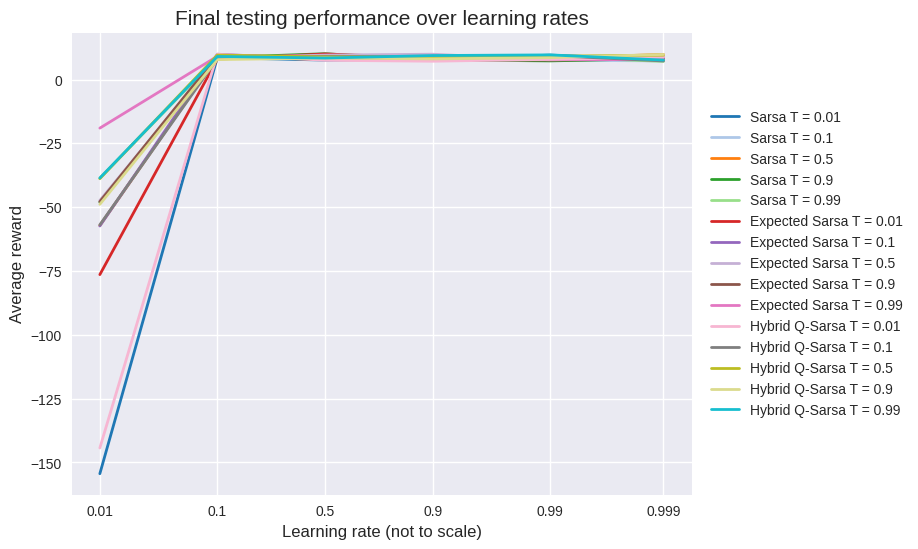

In [ ]:
NUM_COLORS = len(algos) * len(temps)
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(8, 6))
cm = plt.get_cmap('tab20')
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

x = alphas

for algo_i, algo in enumerate(algos):
  for temp_i, temp in enumerate(temps):
    y = []  # the mean reward for each learning rate

    for alpha_i, alpha in enumerate(alphas):
      label = algo_labels[algo_i] + " T = " + str(temp)
      r_array = [] # all the rewards of the last ten training episodes of each trial

      for trial_i in range(trial_n):
        final_test_r = rewards[alpha_i][temp_i][algo_i][trial_i][-1][-1]
        r_array.append(final_test_r)

      mean_r = sum(r_array) / len(r_array)
      y.append(mean_r)

    ax.plot(x, y, linewidth=2, label=label)
    max_y = max(y)
    max_y_index = y.index(max_y)
    print(f'Highest reward for {label} is with alpha = {alphas[max_y_index]} at {max_y}.')

ax.set_xscale('logit')
ax.set(xticks=x)
ax.set_xticklabels(alpha_labels)  # Specify the tick labels
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=1)
ax.set_xlabel("Learning rate (not to scale)", fontsize=12)
ax.set_ylabel("Average reward", fontsize=12)
ax.set_title("Final testing performance over learning rates", fontsize=15)
plt.show()

Highest reward for Sarsa T = 0.01 is with alpha = 0.99 at 9.581895172130576.
Highest reward for Sarsa T = 0.1 is with alpha = 0.1 at 8.593423019615246.
Highest reward for Sarsa T = 0.5 is with alpha = 0.999 at 9.836393915953625.
Highest reward for Sarsa T = 0.9 is with alpha = 0.5 at 10.12381097118333.
Highest reward for Sarsa T = 0.99 is with alpha = 0.99 at 8.854932525144232.
Highest reward for Expected Sarsa T = 0.01 is with alpha = 0.5 at 10.027330994462101.
Highest reward for Expected Sarsa T = 0.1 is with alpha = 0.1 at 9.925856108892772.
Highest reward for Expected Sarsa T = 0.5 is with alpha = 0.9 at 9.931365080199509.
Highest reward for Expected Sarsa T = 0.9 is with alpha = 0.1 at 9.311591844089284.
Highest reward for Expected Sarsa T = 0.99 is with alpha = 0.1 at 9.122674839364107.
Highest reward for Hybrid Q-Sarsa T = 0.01 is with alpha = 0.1 at 9.913329335494756.
Highest reward for Hybrid Q-Sarsa T = 0.1 is with alpha = 0.99 at 9.412921272003848.
Highest reward for Hybrid 

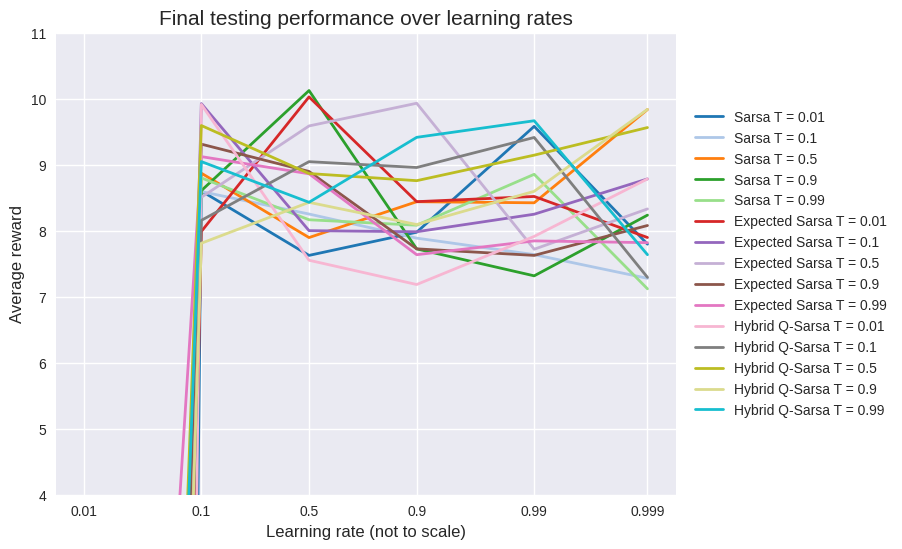

In [ ]:
NUM_COLORS = len(algos) * len(temps)
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(8, 6))
cm = plt.get_cmap('tab20')
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

x = alphas

for algo_i, algo in enumerate(algos):
  for temp_i, temp in enumerate(temps):
    y = []  # the mean reward for each learning rate

    for alpha_i, alpha in enumerate(alphas):
      label = algo_labels[algo_i] + " T = " + str(temp)
      r_array = [] # all the rewards of the last ten training episodes of each trial

      for trial_i in range(trial_n):
        final_test_r = rewards[alpha_i][temp_i][algo_i][trial_i][-1][-1]
        r_array.append(final_test_r)

      mean_r = sum(r_array) / len(r_array)
      y.append(mean_r)

    ax.plot(x, y, linewidth=2, label=label)
    max_y = max(y)
    max_y_index = y.index(max_y)
    print(f'Highest reward for {label} is with alpha = {alphas[max_y_index]} at {max_y}.')


ax.set_ylim(4, 11)
ax.set_xscale('logit')
ax.set(xticks=x)
ax.set_xticklabels(alpha_labels)  # Specify the tick labels
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=1)
ax.set_xlabel("Learning rate (not to scale)", fontsize=12)
ax.set_ylabel("Average reward", fontsize=12)
ax.set_title("Final testing performance over learning rates", fontsize=15)
plt.show()

Highest reward for Sarsa T = 0.01 is with alpha = 0.99 at 9.581895172130576.
Highest reward for Sarsa T = 0.1 is with alpha = 0.1 at 8.593423019615246.
Highest reward for Sarsa T = 0.5 is with alpha = 0.999 at 9.836393915953625.
Highest reward for Sarsa T = 0.9 is with alpha = 0.5 at 10.12381097118333.
Highest reward for Sarsa T = 0.99 is with alpha = 0.99 at 8.854932525144232.
Highest reward for Expected Sarsa T = 0.01 is with alpha = 0.5 at 10.027330994462101.
Highest reward for Expected Sarsa T = 0.1 is with alpha = 0.1 at 9.925856108892772.
Highest reward for Expected Sarsa T = 0.5 is with alpha = 0.9 at 9.931365080199509.
Highest reward for Expected Sarsa T = 0.9 is with alpha = 0.1 at 9.311591844089284.
Highest reward for Expected Sarsa T = 0.99 is with alpha = 0.1 at 9.122674839364107.


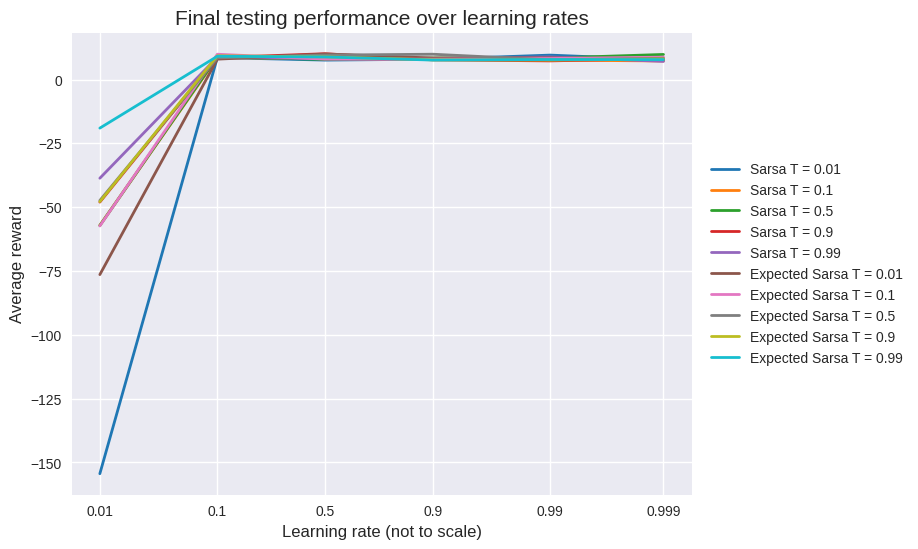

In [ ]:
# plot with only two algorithms
NUM_COLORS = len(two_algos) * len(temps)
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(8, 6))
cm = plt.get_cmap('tab20')
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

x = alphas

for algo_i, algo in enumerate(two_algos):
  for temp_i, temp in enumerate(temps):
    y = []  # the mean reward for each learning rate

    for alpha_i, alpha in enumerate(alphas):
      label = algo_labels[algo_i] + " T = " + str(temp)
      r_array = [] # all the rewards of the last ten training episodes of each trial

      for trial_i in range(trial_n):
        final_test_r = rewards[alpha_i][temp_i][algo_i][trial_i][-1][-1]
        r_array.append(final_test_r)

      mean_r = sum(r_array) / len(r_array)
      y.append(mean_r)

    ax.plot(x, y, linewidth=2, label=label)
    max_y = max(y)
    max_y_index = y.index(max_y)
    print(f'Highest reward for {label} is with alpha = {alphas[max_y_index]} at {max_y}.')

ax.set_xscale('logit')
ax.set(xticks=x)
ax.set_xticklabels(alpha_labels)  # Specify the tick labels
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=1)
ax.set_xlabel("Learning rate (not to scale)", fontsize=12)
ax.set_ylabel("Average reward", fontsize=12)
ax.set_title("Final testing performance over learning rates", fontsize=15)
plt.show()

Highest reward for Sarsa T = 0.01 is with alpha = 0.99 at 9.581895172130576.
Highest reward for Sarsa T = 0.1 is with alpha = 0.1 at 8.593423019615246.
Highest reward for Sarsa T = 0.5 is with alpha = 0.999 at 9.836393915953625.
Highest reward for Sarsa T = 0.9 is with alpha = 0.5 at 10.12381097118333.
Highest reward for Sarsa T = 0.99 is with alpha = 0.99 at 8.854932525144232.
Highest reward for Expected Sarsa T = 0.01 is with alpha = 0.5 at 10.027330994462101.
Highest reward for Expected Sarsa T = 0.1 is with alpha = 0.1 at 9.925856108892772.
Highest reward for Expected Sarsa T = 0.5 is with alpha = 0.9 at 9.931365080199509.
Highest reward for Expected Sarsa T = 0.9 is with alpha = 0.1 at 9.311591844089284.
Highest reward for Expected Sarsa T = 0.99 is with alpha = 0.1 at 9.122674839364107.


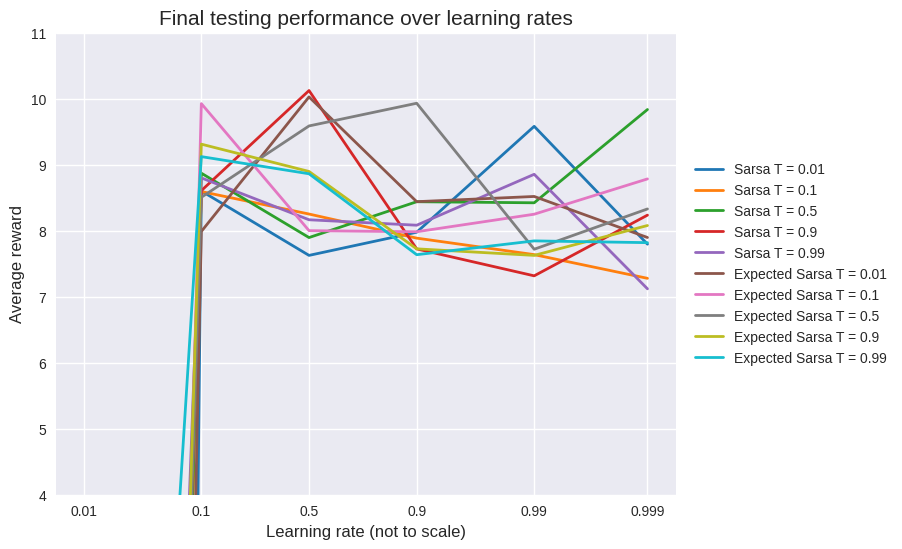

In [ ]:
# plot with only two algorithms
NUM_COLORS = len(two_algos) * len(temps)
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(8, 6))
cm = plt.get_cmap('tab20')
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

x = alphas

for algo_i, algo in enumerate(two_algos):
  for temp_i, temp in enumerate(temps):
    y = []  # the mean reward for each learning rate

    for alpha_i, alpha in enumerate(alphas):
      label = algo_labels[algo_i] + " T = " + str(temp)
      r_array = [] # all the rewards of the last ten training episodes of each trial

      for trial_i in range(trial_n):
        final_test_r = rewards[alpha_i][temp_i][algo_i][trial_i][-1][-1]
        r_array.append(final_test_r)

      mean_r = sum(r_array) / len(r_array)
      y.append(mean_r)

    ax.plot(x, y, linewidth=2, label=label)
    max_y = max(y)
    max_y_index = y.index(max_y)
    print(f'Highest reward for {label} is with alpha = {alphas[max_y_index]} at {max_y}.')

ax.set_ylim(4, 11)
ax.set_xscale('logit')
ax.set(xticks=x)
ax.set_xticklabels(alpha_labels)  # Specify the tick labels
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=1)
ax.set_xlabel("Learning rate (not to scale)", fontsize=12)
ax.set_ylabel("Average reward", fontsize=12)
ax.set_title("Final testing performance over learning rates", fontsize=15)
plt.show()

### Plot 3
Learning curves (mean and standard deviation computed based on the 10 runs) for the best parameter setting for each algorithm. X-axis shows the segment, Y-axis shows return over-
time.

Hyperparameters are chosen based on testing performance.


In [ ]:
# best params
sarsa_params_indices = [2, 3]  # 0.5, 0.9
expected_sarsa_params_indices = [2, 0]  # 0.5, 0.01
hybrid_sarsa_params_indices = [1, 0]  # 0.1, 0.01
algo_params_indices = [sarsa_params_indices, expected_sarsa_params_indices, hybrid_sarsa_params_indices]

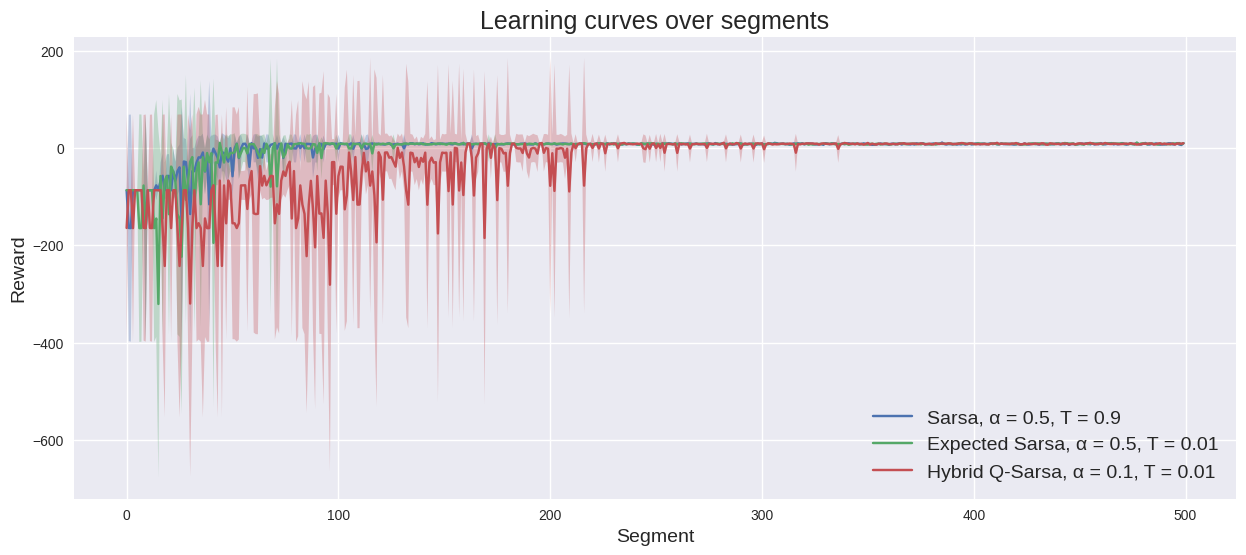

In [ ]:
NUM_COLORS = len(algos)
plt.style.use('seaborn-v0_8')
cm = plt.get_cmap('tab10')
fig, ax = plt.subplots(figsize=(15, 6))

x = range(500)

for algo_i, algo in enumerate(algos):

  rewards_over_trial = []

  for trial_i in range(trial_n):
    reward_over_trial = []
    for seg_i in range(segment_n):
      alpha_i = algo_params_indices[algo_i][0]
      temp_i = algo_params_indices[algo_i][1]
      reward_over_trial.append(rewards[alpha_i][temp_i][algo_i][trial_i][seg_i][-1])
    rewards_over_trial.append(reward_over_trial)

  rewards_over_trial = np.asarray(rewards_over_trial)
  mean_rewards_over_trial = np.mean(rewards_over_trial, axis=0)
  std_dev_rewards_over_trial = np.std(rewards_over_trial, axis=0)

  label = f'{algo_labels[algo_i]}, \u03B1 = {alphas[algo_params_indices[algo_i][0]]}, T = {temps[algo_params_indices[algo_i][1]]}'
  ax.plot(mean_rewards_over_trial, label = label)

  y1 = mean_rewards_over_trial - std_dev_rewards_over_trial
  y2 = mean_rewards_over_trial + std_dev_rewards_over_trial
  ax.fill_between(range(0,500), y1, y2, alpha=0.3)

ax.legend(loc='lower right', fontsize=14)
# ax.set(xticks=x)
ax.set_xlabel("Segment", fontsize=14)
ax.set_ylabel("Reward", fontsize=14)
ax.set_title("Learning curves over segments", fontsize=18)
plt.show()

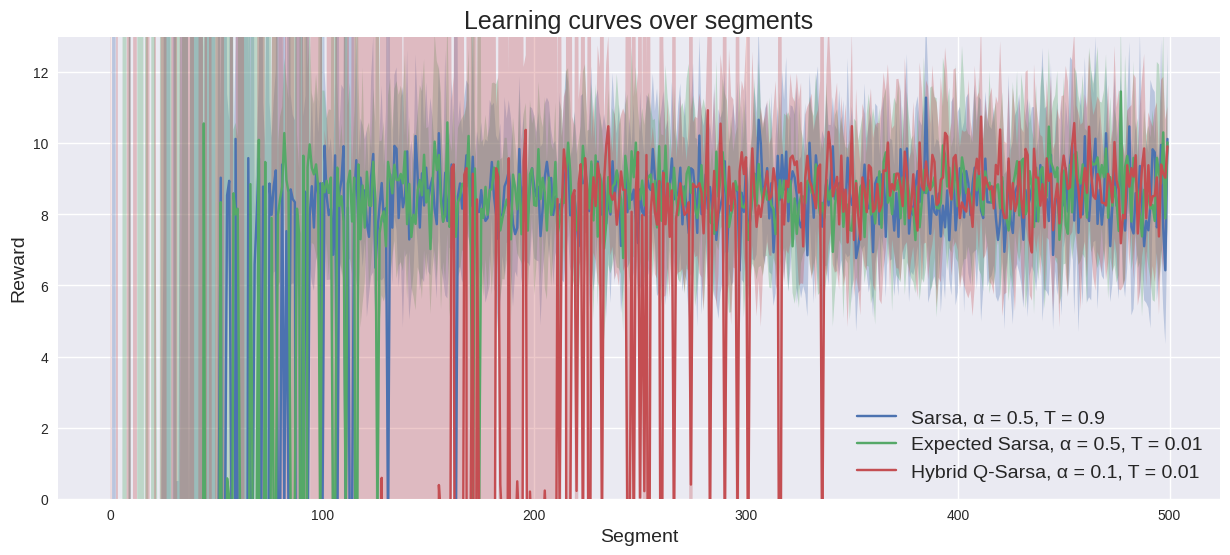

In [ ]:
NUM_COLORS = len(algos)
plt.style.use('seaborn-v0_8')
cm = plt.get_cmap('tab10')
fig, ax = plt.subplots(figsize=(15, 6))

x = range(500)

for algo_i, algo in enumerate(algos):

  rewards_over_trial = []

  for trial_i in range(trial_n):
    reward_over_trial = []
    for seg_i in range(segment_n):
      alpha_i = algo_params_indices[algo_i][0]
      temp_i = algo_params_indices[algo_i][1]
      reward_over_trial.append(rewards[alpha_i][temp_i][algo_i][trial_i][seg_i][-1])
    rewards_over_trial.append(reward_over_trial)

  rewards_over_trial = np.asarray(rewards_over_trial)
  mean_rewards_over_trial = np.mean(rewards_over_trial, axis=0)
  std_dev_rewards_over_trial = np.std(rewards_over_trial, axis=0)

  label = f'{algo_labels[algo_i]}, \u03B1 = {alphas[algo_params_indices[algo_i][0]]}, T = {temps[algo_params_indices[algo_i][1]]}'
  ax.plot(mean_rewards_over_trial, label = label)

  y1 = mean_rewards_over_trial - std_dev_rewards_over_trial
  y2 = mean_rewards_over_trial + std_dev_rewards_over_trial
  ax.fill_between(range(0,500), y1, y2, alpha=0.3)

ax.legend(loc='lower right', fontsize=14)
ax.set_ylim(0, 13)
# ax.set(xticks=x)
ax.set_xlabel("Segment", fontsize=14)
ax.set_ylabel("Reward", fontsize=14)
ax.set_title("Learning curves over segments", fontsize=18)
plt.show()